# Activity 4: Solve problems in Python

It is now up to you to you to find a solution to model the Boston house prices. There are non-linear relationships and the data are non-normal (you can check activity 3 for this). You should come up with a strategy to solve these problems. Make sure that you test whether the assumptions are not violated afterwards. Finally, select the best model and compare the performance of this model with the original one.

In [1]:
#Load the boston housing data set
import numpy as np
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm

dataset = datasets.load_boston()

#Separate the variables and the target
X = dataset['data']
y = dataset['target']

#Set as a Pandas data frame
var_names = dataset['feature_names']
data = pd.DataFrame(X)
data.columns = var_names
data['TARGET'] = pd.DataFrame(y)

#Limit the colums to TARGET, RM, and LSTAT
data = data[['TARGET', 'RM', 'LSTAT']]

data.head(n=10)

,TARGET,RM,LSTAT
0,24.0,6.575,4.98
1,21.6,6.421,9.14
2,34.7,7.185,4.03
3,33.4,6.998,2.94
4,36.2,7.147,5.33
5,28.7,6.430,5.21
6,22.9,6.012,12.43
7,27.1,6.172,19.15
8,16.5,5.631,29.93
9,18.9,6.004,17.10


## Polynomial regression

### Assumptions

Here, we will add a polynomial term for *LSTAT*. We will then rebuild the model and check the assumptions again.  

In [2]:
def make_poly(data, power, var):
    
    #power is the degree of polynomial you want to add
    #var is the variable you want to add a polynomial term
    
    ### BEGIN SOLUTION
    #Add a constant first
    data_const = sm.add_constant(data)
    #Add a polynomial term
    data_const["LSTAT2"] = np.power(data_const[var], power)
    #Fit a polynomial regression
    lm2 = sm.OLS(data_const["TARGET"],data_const[["const","RM", "LSTAT", "LSTAT2"]]).fit()
    ### END SOLUTION
    
    return lm2

Verify your results:

In [3]:
lm2 = make_poly(data,2,"LSTAT")

assert np.allclose(lm2.params, (11.68964028,   4.22726512,  -1.8486336 ,   0.03633861))

In [4]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     396.2
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          6.50e-132
Time:                        18:10:30   Log-Likelihood:                -1533.0
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     502   BIC:                             3091.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6896      3.138      3.725      0.0

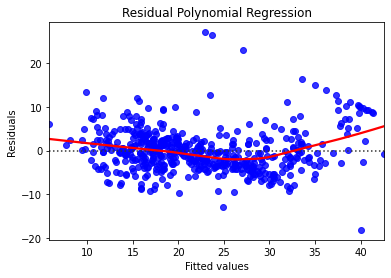

In [5]:
import seaborn as sea
import matplotlib.pyplot as plt

#Make a residual plot
plot_resid = sea.residplot(lm2.fittedvalues, 'TARGET', data=data, 
                          lowess=True, 
                          scatter_kws={'color': 'blue'}, 
                          line_kws={'color': 'red'})
plot_resid.axes.set_title('Residual Polynomial Regression')
plot_resid.axes.set_xlabel('Fitted values')
plot_resid.axes.set_ylabel('Residuals')

plt.show()

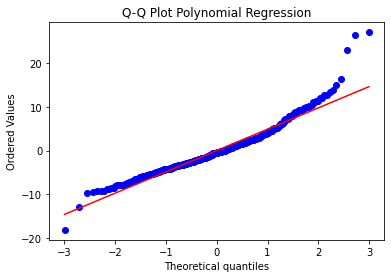

In [6]:
#QQ-plot
import scipy.stats as stats
stats.probplot(lm2.resid, plot= plt)
plt.title("Q-Q Plot Polynomial Regression")
plt.show()

From the residual plot, we see that the points are scattered around the horizontal line, without a specific shape. Notice that the smoother curve shows a certain pattern, but the line is quasi-horizontal. This serves as enough evidence that there is a linear relationship between the predictors. Futhermore, there is no hetereoscedasticity since there is no funnel shape whatsoever. 

Looking at the Q-Q plot, we see that solving the non-linearity assumption also solved the normality assumption. Although, we see that there are some outliers at the end of the Q-Q plot that deviate from the 45-degree line. Also in the residual plot, we see that there are some outliers that might clutter the relationship. To test this, we will make the model again without outliers and test predictive performance. 

### Outlier removal

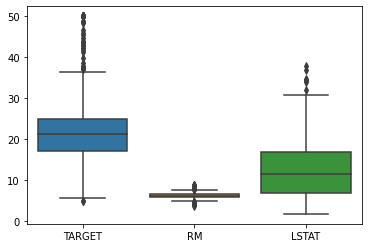

In [7]:
#Detect outliers using a box plot
#Do this on the original data set, since we are not interested in outliers in the const nor the polynomial term
sea.boxplot(data=data)
plt.show()

In [8]:
#Detect outliers: get the min and the max of the box plot and delete those observations that are not in this range.
def get_outliers(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    return min,max

In [9]:
#Make a function that deletes the outliers of TARGET, LSTAT and RM
def rm_outliers (data, var):
    outliers = []
    #detect outliers for each variable
    for i in var:
        outliers.append(get_outliers(data[var]))
        
    #Delete them for each var
    data_no = data[((data[var[0]]>outliers[0][0]) & (data[var[0]]<outliers[0][1])) &
                          ((data[var[1]]>outliers[1][0]) & (data[var[1]]<outliers[1][1])) &
                          ((data[var[2]]>outliers[2][0]) & (data[var[2]]<outliers[2][1]))]
    return data_no

Verify your results: 

In [10]:
data_const = sm.add_constant(data)
data_no = rm_outliers(data_const, ['TARGET', 'LSTAT', 'RM'])
print(data_no)

     const  TARGET     RM  LSTAT
0      1.0    24.0  6.575   4.98
1      1.0    21.6  6.421   9.14
2      1.0    34.7  7.185   4.03
3      1.0    33.4  6.998   2.94
4      1.0    36.2  7.147   5.33
..     ...     ...    ...    ...
501    1.0    22.4  6.593   9.67
502    1.0    20.6  6.120   9.08
503    1.0    23.9  6.976   5.64
504    1.0    22.0  6.794   6.48
505    1.0    11.9  6.030   7.88

[475 rows x 4 columns]


In [12]:
#Now that the outliers are removed, you can make a linear regression model without outliers
#Make a linear regression model without outliers
#Make one for the normal regression and the polynomial one
data_no = data_no.assign(LSTAT2=np.power(data_no.LSTAT, 2).values)
lm1_no = sm.OLS(data_no['TARGET'],data_no[['const','RM', 'LSTAT']]).fit()
lm2_no = sm.OLS(data_no['TARGET'],data_no[['const','RM', 'LSTAT', 'LSTAT2']]).fit()

In [13]:
print(lm1_no.summary())
print(lm2_no.summary())

                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     408.6
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          1.04e-103
Time:                        18:10:31   Log-Likelihood:                -1345.3
No. Observations:                 475   AIC:                             2697.
Df Residuals:                     472   BIC:                             2709.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2403      2.727      4.855      0.0

### Prediction

Compare all the models (with and without outliers) to see which one performs best. We will use 5-fold cross-validation since this gives us the best idea of the true error rate of all the models. 

In [14]:
np.random.seed(40) 

#Make function that calculates RMSE, MAE, and R2 using 5cv
def calculate_performance(X, y, nFold):    
    
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2
    from math import sqrt
    
    ### BEGIN SOLUTION
    predictions = cross_val_predict(LinearRegression(), X, y, cv=nFold)
    
    RMSE = sqrt(mse(y, predictions))
    MAE = mae(y, predictions)
    R2 = r2(y, predictions)
    
    measures = {'rmse': RMSE, 'mae': MAE, 'r2': R2}
    ### END SOLUTION
    
    return measures

In [15]:
data_const["LSTAT2"] = np.power(data_const.LSTAT, 2)

#Calculate the performance of all models and print out
#Scikit already adds an intercept so do not add the intercept to your models
perf1 = calculate_performance(data_const[["RM","LSTAT"]],data_const["TARGET"],5)
perf1_no = calculate_performance(data_no[["RM","LSTAT"]],data_no["TARGET"],5)
perf2 = calculate_performance(data_const[["RM","LSTAT", "LSTAT2"]],data_const["TARGET"],5)
perf2_no = calculate_performance(data_no[["RM", "LSTAT", "LSTAT2"]],data_no["TARGET"],5)

print("MLR with outliers: ", perf1, "\nMLR no outliers: ", perf1_no, "\nPolynomial MLR with outliers: ", perf2, "\nPolynomial MLR no outliers: ", perf2_no)

MLR with outliers:  {'rmse': 6.272361123675099, 'mae': 4.425237658101086, 'r2': 0.5339644525847537} 
MLR no outliers:  {'rmse': 4.611645776722151, 'mae': 3.5713018189294434, 'r2': 0.5389405000430247} 
Polynomial MLR with outliers:  {'rmse': 5.608640138264115, 'mae': 4.101505787128055, 'r2': 0.6273749160401162} 
Polynomial MLR no outliers:  {'rmse': 4.237535964538167, 'mae': 3.3361145683065163, 'r2': 0.6107112204592527}


We see that in terms of error rate, outlier removal is important, even more important than finding the correct shape of the regression line. The error rates (RMSE and MAE) are bigger for the polynomial model with outliers than the standard model without outliers. However, having the correct functional form is important in terms of R-squared. We see that this one is always larger when you add the polynomial term. This means that our model explains more of the variation in the house prices. 

In general, we could say that removing the outliers is important for the error rate. Adding the polynomial term is important for the general model fit. However, it does not significantly decrease the error rates as much as removing the outliers. One thing to bear in mind is that adding the polynomial term will make sure that the linearity assumption is not violated. 

Even with removing the outliers, the residual plot would still indicate that there is a non-linear relationship when you don't add the polynomial term. So the preferred model in this case would be the one removing the outliers and adding the polynomial term.

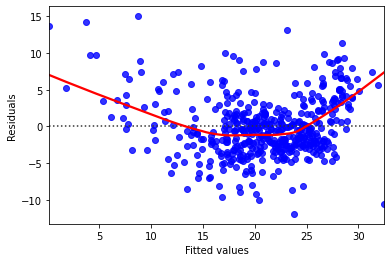

In [16]:
#Residual plot without outliers and no polynomial term
plot_resid = sea.residplot(lm1_no.fittedvalues, 'TARGET', data=data_no, 
                          lowess=True, 
                          scatter_kws={'color': 'blue'}, 
                          line_kws={'color': 'red'})
plot_resid.axes.set_xlabel('Fitted values')
plot_resid.axes.set_ylabel('Residuals')

plt.show()

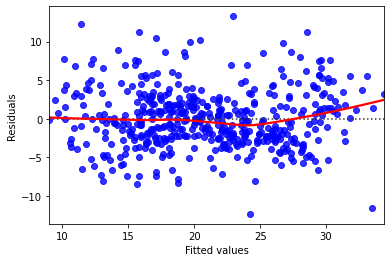

In [17]:
#Residual plot without outliers and polynomial term
plot_resid = sea.residplot(lm2_no.fittedvalues, 'TARGET', data=data_no, 
                          lowess=True, 
                          scatter_kws={'color': 'blue'}, 
                          line_kws={'color': 'red'})
plot_resid.axes.set_xlabel('Fitted values')
plot_resid.axes.set_ylabel('Residuals')

plt.show()